# Evaluate and compare the discrimination of two trained models

## Objectives
- Build and interpret ROC curves on train and test sets
- Calculate and interpret the AUC on train and test sets
- Bootstrap multiple AUCs at once to calculate confidence intervals
- Review important concepts on hypothesis testing
- Test if (in the population from which we're sampling) the AUCs of two models are different 
    - Approach based on confidence intervals
    - Approach based on DeLong test (see implementions in Python and R)
- Conduct a simulation study to evaluate the power a bigger test set would yield to detect differences in AUCs

### Important note before we start
In this workshop, we will be focusing on one aspect of model performance: discrimination. However, it's important to note that calibration is another equally, if not more, important aspect of model performance. Calibration and discrimination are related in interesting ways, and it's crucial to evaluate both.

In a highly cited paper titled ["Use and misuse of the receiver operating characteristic curve in risk prediction,"](https://www.ahajournals.org/doi/10.1161/CIRCULATIONAHA.106.672402?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) Nancy Cook noted:

> "Calibration has largely been overlooked in discussions of model fit [...] There is, in fact, a trade-off between discrimination and calibration, and a model typically cannot be perfect in both."

### Setup

Import libraries relevant to this workshop

In [1]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

You may need to run the following commands to install the speedboot library <br>
`!pip install speedboot` 

In [2]:
# For bootstrapping multiple statistics at once, using parallel processing
from speedboot import speedboot

### Load data and models

This part is not specific to this workshop and can be skipped without loss of generality

In [3]:
import pickle
with open('data_and_models.pkl', 'rb') as f:
    data_and_models = pickle.load(f)

# Access the saved variables like this:
TX_train = data_and_models['TX_train']
TX_test = data_and_models['TX_test']
Y_bin_train = data_and_models['Y_bin_train']
Y_bin_test = data_and_models['Y_bin_test']
TX_train_mean = data_and_models['TX_train_mean']
TX_train_std = data_and_models['TX_train_std']
rf = data_and_models['rf']
calibrated_rf = data_and_models['calibrated_rf']
mlp = data_and_models['mlp']

# these are our models
def final_rf(TX_data):
    TX_data_norm = (TX_data - TX_train_mean) / TX_train_std
    return calibrated_rf.predict_proba(TX_data_norm)[:,1]

def final_mlp(TX_data):
    TX_data_norm = (TX_data - TX_train_mean) / TX_train_std
    return mlp.predict(TX_data_norm, verbose=0)[:,0]

### Build and interpret ROC curves on train and test sets

To build ROC curves and calculate the AUC, we'll use the `roc_curve` and `auc` functions from `sklearn`

In [4]:
def roc_measures(Y, Y_hat):
    # Compute ROC curve and AUC given true labels and predicted probabilities
    fpr, tpr, thresholds = roc_curve(Y, Y_hat) # gets (1-specificity) and sensitivity, for all thresholds
    roc_auc = auc(fpr, tpr) # computes the area under the curve
    return fpr, tpr, thresholds, roc_auc

Apply `roc_measures` on the train set

In [5]:
# For the random forest model
rf_fpr_train, rf_tpr_train, rf_thresholds_train, rf_auc_train = roc_measures(Y_bin_train, final_rf(TX_train))

# For the multi-layer perceptron model
mlp_fpr_train, mlp_tpr_train, mlp_thresholds_train, mlp_auc_train = roc_measures(Y_bin_train, final_mlp(TX_train))

Apply `roc_measures` on the test set

In [6]:
# For the random forest model
rf_fpr, rf_tpr, rf_thresholds, rf_auc = roc_measures(Y_bin_test, final_rf(TX_test))

# For the multi-layer perceptron model
mlp_fpr, mlp_tpr, mlp_thresholds, mlp_auc = roc_measures(Y_bin_test, final_mlp(TX_test))

Here's a handy function for plotting ROC curves

In [7]:
def plot_roc(fpr, tpr, thresholds, auc, mod_name="model"):
    train_plot = plt.plot(fpr, tpr, label=f'{mod_name} (AUC = {auc:.3f})', lw=3)
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate=1 - Specificity')
    plt.ylabel('True Positive Rate=Sensitivity')
    plt.legend(loc="lower right");

Plot the ROC curves

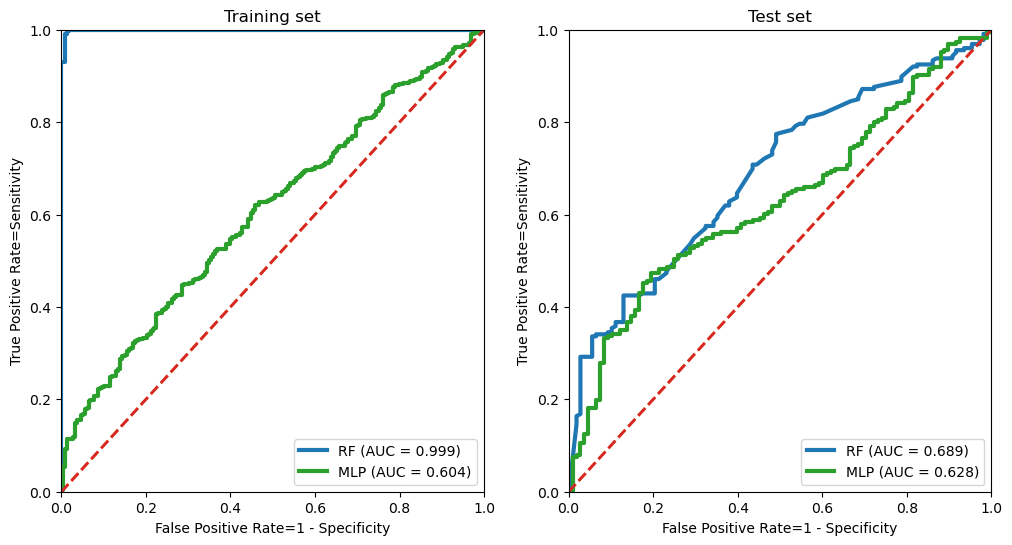

In [8]:
plt.figure(figsize=(12, 6))

# Subplot for the training set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plot_roc(*roc_measures(Y_bin_train, final_rf(TX_train)), mod_name="RF")
plot_roc(*roc_measures(Y_bin_train, final_mlp(TX_train)), mod_name="MLP")
plt.title('Training set')

# Subplot for the test set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plot_roc(*roc_measures(Y_bin_test, final_rf(TX_test)), mod_name="RF")
plot_roc(*roc_measures(Y_bin_test, final_mlp(TX_test)), mod_name="MLP")
plt.title('Test set');

The area under this ROC curve is called AUC or C-statistic. It is a probability and thus has values between 0 and 1. Higher values correspond to higher discriminative abilities for the model. A value of 0.5 indicates that the model makes predictions that are no better than predictions from the flip of a coin (purely random predictions).

Note that the random forest achieves perfect discrimination (AUC~1) on the training set but AUC drops when evaluation is performed on the test set. <br>
    - Remember that performance on the training set is irrelevant: by overfitting, we can always get zero error on the training set. <br>
Nonetheless the random forest achieves decent performance on the test set <br>
    - This behavior is frequent with random forest: they often interpolate the training data (ie, zero training error) and yet achieve very good test error. <br>

## Bootstrap multiple AUCs at once to calculate confidence intervals

The bootstrap in its standard form is just a method for obtaining lots of new datasets of the same size as the original by sampling with replacement.

<img src="bootstrap.jpeg" width="1000"/>

To prepare for bootstrapping, let's put all the data we are interested in a Pandas DataFrame (a np.array would work too)

In [9]:
data_mod = pd.DataFrame({'y':Y_bin_test, 'y_hat_rf':final_rf(TX_test), 'y_hat_mlp':final_mlp(TX_test)})

# Check the first 10 rows
data_mod.head(10)

,y,y_hat_rf,y_hat_mlp
0,1,0.584183,0.414781
1,1,0.610146,0.423849
2,1,0.559381,0.443536
3,1,0.941799,0.507029
4,1,0.596773,0.427111
5,0,0.765608,0.422777
6,0,0.552552,0.464925
7,0,0.584183,0.513314
8,1,0.549592,0.393549
9,0,0.673109,0.474251


Here's the general recipe to bootstrap multiple statistics at once.
1. Define a function that does something (possibly something nonparametric and complex) to this data and returns a np.array

In [10]:
def boot_fun(data):
    # Takes data as input and returns the AUC for the random forest and MLP models
    _, _, _, roc_rf_auc = roc_measures(data['y'], data['y_hat_rf'])
    _, _, _, roc_mlp_auc = roc_measures(data['y'], data['y_hat_mlp'])
    return np.array([roc_rf_auc, roc_mlp_auc])

2. Check that the function works on the complete data

In [11]:
boot_fun(data_mod)

array([0.68856522, 0.62782694])

3. Now for the bootstrapping of two statistics at once

In [12]:
# Instanciate a speedboot object with the data and the function
sb_object = speedboot(data=data_mod, stats_fun=boot_fun)

# Run the bootstrap as follows
sb_object.fit(R=9999, # number of bootstrap samples
            par=True, # use parallel processing to speed up the computation
            seed=42) # set the seed for reproducibility

100%|██████████| 9999/9999 [00:01<00:00, 5516.76it/s]


Check the distribution of each of the bootstrapped AUCs for the Random Forrest (estimate 1) and for the Multi-Layer Perceptron Forrest (estimate 2.)

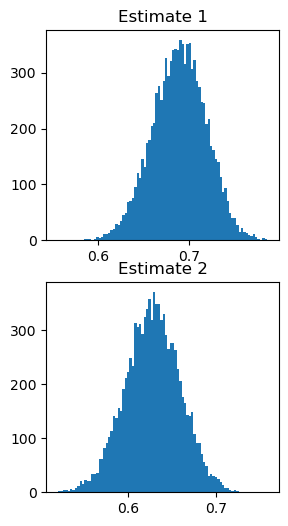

In [13]:
sb_object.plot(prec=0.01, size=3)

The easiest way to build 95% bootstrap confidence intervals, is to take the 2.5% and 97.5% quantiles from these distributions. This is called the percentile method. It can be obtained as follows.

In [14]:
print("On the test set, the AUC for:")
print(f"- Random Forrest is {rf_auc:.3f}; 95% CI (percentile bootstrap) {sb_object.per_ci(alpha=.05)[0].round(3)}")
print(f"- Multi-Layer Perceptron is {mlp_auc:.3f}; 95% CI (percentile bootstrap) {sb_object.per_ci(alpha=.05)[1].round(3)}")

On the test set, the AUC for:
- Random Forrest is 0.689; 95% CI (percentile bootstrap) [0.63  0.744]
- Multi-Layer Perceptron is 0.628; 95% CI (percentile bootstrap) [0.567 0.688]


Note that there exist other methods to build confidence intervals from the bootstrap. For example, the empirical method or the BCa method. These are in theory more robust than the percentile method. However, in practice, they often yield similar results. The code to compute these is provided below.

In [15]:
print("On the test set, the AUC for:")
print(f"- Random Forrest is {rf_auc:.3f}; 95% CI (empirical bootstrap) {sb_object.emp_ci(alpha=.05)[0].round(3)}")
print(f"- Multi-Layer Perceptron is {mlp_auc:.3f}; 95% CI (empirical bootstrap) {sb_object.emp_ci(alpha=.05)[1].round(3)}")

On the test set, the AUC for:
- Random Forrest is 0.689; 95% CI (empirical bootstrap) [0.633 0.747]
- Multi-Layer Perceptron is 0.628; 95% CI (empirical bootstrap) [0.567 0.689]


In [16]:
# For BCa bootstrap, we need to compute the jackknife estimates first
sb_object.jackknife(bar=True, par=True)

print("\nOn the test set, the AUC for:")
print(f"- Random Forrest is {rf_auc:.3f}; 95% CI (BCa bootstrap) {sb_object.bca_ci(alpha=.05)[0].round(3)}")
print(f"- Multi-Layer Perceptron is {mlp_auc:.3f}; 95% CI (BCa bootstrap) {sb_object.bca_ci(alpha=.05)[1].round(3)}")

100%|██████████| 334/334 [00:00<00:00, 2511.57it/s]


On the test set, the AUC for:
- Random Forrest is 0.689; 95% CI (BCa bootstrap) [0.627 0.742]
- Multi-Layer Perceptron is 0.628; 95% CI (BCa bootstrap) [0.565 0.687]


## A short informal review of hypothesis testing

Let's call the AUC of the random forrest $\hat{\theta}_{RF}$ and AUC of the Multi-Layer Perceptron $\hat{\theta}_{MLP}$. We use a hat on the greek letters (prononce "theta hat RF" and "theta hat MLP") to indicate that these are random variables (they change from sample to sample as bootstrapping reveals). We drop hats when we speak about the true AUCs from the underlying population. To compare the two models, what we really want is to build a confidence interval for the difference in the true AUCs: $$\text{CI}_{95\%}(\theta_{RF}-\theta_{MLP})=(\hat{\theta}_{RF}-\hat{\theta}_{MLP})±1.96\sqrt{\text{VAR}(\hat{\theta}_{RF}-\hat{\theta}_{MLP})}.$$ If this interval does not cross zero, we can conlude, at the $.05$ alpha risk, that $\theta_{RF}\neq\theta_{MLP}$ (ie, the alternative hypothesis is true). Otherwise, we can't say anything (in particular, we can't conclude that the null hypothesis $\theta_{RF}=\theta_{MLP}$ is true!)

<font color='red'><b>For proper inference, we are not allowed to check if confidence intervals for the AUC of two models overlap!</b></font><br>This is because $\text{VAR}(\hat{\theta}_{RF}-\hat{\theta}_{MLP})=\text{VAR}(\hat{\theta}_{RF})+\text{VAR}(\hat{\theta}_{MLP})-\text{COV}(\hat{\theta}_{RF},\hat{\theta}_{MLP}).$
When we built 95% CI for $\theta_{RF}$ and $\theta_{MLP}$ we only focused on $\text{VAR}(\hat{\theta}_{RF})$ and $\text{VAR}(\hat{\theta}_{MLP})$. But that's not enough because $\text{COV}(\hat{\theta}_{RF},\hat{\theta}_{MLP})\neq0.$ In fact, it's most often positive. If you wanted to see this in action, you could make a scatter plot of the bootstrap estiamtes $(\hat{\theta}_{RF}^{(r)}, \hat{\theta}_{MLP}^{(r)})_{1\leq r\leq R}$ and contemplate the correlation.

## Approach based on confidence intervals

We already computed and stored the RF's AUCs and the MLP's AUC for 9999 bootstrap samples. For each bootstrap sample, we just need to take their difference.

In [17]:
# Bootstrap estimates for the difference in AUC
diff_boot = sb_object.ests_boot[:,0] - sb_object.ests_boot[:,1]

# Implement the percentile bootstrap ourselves
diff_ci = np.nanquantile(sb_object.ests_boot[:,0] - sb_object.ests_boot[:,1], [0.05/2, 1-0.05/2])

# Get the difference in AUC for the test set
diff = rf_auc - mlp_auc

print("\nOn the test set, difference in AUC (RF - MLP) is")
print(f"{rf_auc:.3f} - {mlp_auc:.3f} = {diff:.3f}; 95% CI (percentile bootstrap) {diff_ci.round(3)}")

if diff_ci[0] * diff_ci[1] < 0:
    print("At the .05 alpha threshold, we cannot conclude anything.")
else:
    print("At the .05 alpha threshold, we conclude that the true AUCs of the random forrest and the multi-layer perceptron are statistically different.")


On the test set, difference in AUC (RF - MLP) is
0.689 - 0.628 = 0.061; 95% CI (percentile bootstrap) [-0.02   0.143]
At the .05 alpha threshold, we cannot conclude anything.


## Approach based on DeLong test

In 1988, Elizabeth DeLong et al. proposed a hypothesis testing procedure that can be used to show that the AUCs of two models are statistically significantly different. In their paper, they leverage previously published results detailing the asymptotic properties of U-statistics. They notice that the AUC is a U-statistic: to calculate it, we need to consider all possible pairs of observations with $Y=1$ and $Y=0$. The technical details are beyond the scope of this workshop, but we will show how to compute p-values from DeLong's test in both `Python` and `R`.

In [18]:
import compare_auc_delong_xu

# Define a handy function to directly compute the p-value from the DeLong test
def delong_p_value(y, y_hat_1, y_hat_2):
    return 10 ** compare_auc_delong_xu.delong_roc_test(y, y_hat_1, y_hat_2)[[0]].item()

To compare the population AUCs for RF and MLP, calculate the p-value from DeLong test

In [19]:
delong_p = delong_p_value(data_mod['y'],  data_mod['y_hat_rf'], data_mod['y_hat_mlp'])
print(f'The P-value from the DeLong test is {delong_p:.3f}')

The P-value from the DeLong test is 0.144


The DeLong test is directly implemented in the `R` package `pROC`. Running `pROC` from `Python` is a bit annoying but manageable. <br>
For that you may need to use `!pip install rpy2`. Then, provided `R` is installed, you'll be able to run `R` code from within `Python`.

In [20]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

# Import the pROC library
pROC = importr('pROC')

# Here is the R script to compute the p-value from the DeLong test
r_script = """
roc_rf <- roc(data_mod$y, data_mod$y_hat_rf)
roc_mlp <- roc(data_mod$y, data_mod$y_hat_mlp)
roc.test(roc_rf, roc_mlp, method="delong")$p.value
"""

# Enable automatic conversion from pandas to R
pandas2ri.activate()

# Convert the pandas DataFrame to an R data.frame
data_mod_r = pandas2ri.py2rpy(data_mod)

# Assign the R data.frame to an R variable
robjects.globalenv['data_mod'] = data_mod_r

# Run the R script
delong_p_R = robjects.r(r_script)

# Convert the result to a Python float
delong_p_R = delong_p_R[0]

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



In [21]:
print(f"The p-value for the DeLong test calculated in R is {delong_p_R:.10f} vs {delong_p:.10f} in Python.")
if abs(delong_p_R - delong_p) < 10**-10:
    print("So, our implementation in Python is (almost surely) correct.")

The p-value for the DeLong test calculated in R is 0.1439444344 vs 0.1439444344 in Python.
So, our implementation in Python is (almost surely) correct.


## Conduct a simulation study to evaluate the power a bigger test set would yield to detect differences in AUCs

Maybe we couldn't conclude that the true AUCs of the two models were different because...<br>
- Well, they weren't.
- Or, maybe it's because we had too small a test set (ie we made a type II error). <br>

If we assume the latter then the next question is: how big my test set should be to detect the difference?

To answer this question, we will conduct a little simulation study to see what would happen if we had a test set "like" our original test set but bigger! To achieve this we will sample with replacement from our original test set to construct:
- 1000 datasets of size 500
- 1000 datasets of size 1000
- 1000 datasets of size 1500
- 1000 datasets of size 2000
- 1000 datasets of size 2500
- 1000 datasets of size 3000

In each of these dataset, we will calculate a p-value from DeLong test. Let's go!

In [22]:
# 1000 simulated datasets
n_sim = 1000

# Sample sizes to consider
sample_sizes = np.array([500, 1000, 1500, 2000, 2500, 3000])

# Prepare to store the all the p-values
sim_res = []

# Loop over the number of simulations
for _ in range(n_sim):
    # Sample with replacement ss indices of the test set (where ss is one of the sample sizes)
    ids_list = [random.choices(range(len(Y_bin_test)), k=ss) for ss in sample_sizes]
    # Compute a p-value for each sample size
    sim_res.append([delong_p_value(data_mod['y'][ids],  data_mod['y_hat_rf'][ids], data_mod['y_hat_mlp'][ids]) for ids in ids_list])

# Convert the list to a numpy array
sim_res = np.array(sim_res)

Now, the results of our simulation (ie., all the p-values) are stored in `sim_res`: a 1000 x 6 numpy array. 

In [23]:
# Let's get the mean p-values for each sample size
mean_pvals =sim_res.mean(axis=0)

# For each sample size, let's get the proportion of p-values below 0.05
# (This is the power of the test at the 0.05 alpha threshold)
powers = (sim_res < 0.05).mean(axis=0)

Let's get ready for the plot.

In [24]:
# Let's prepare the data for the plot
x = np.concatenate([np.repeat(sample_size, n_sim) for sample_size in sample_sizes])

# Add some jitter to the x values
l = sample_sizes[1] - sample_sizes[0]
jit = np.random.uniform(-l*.1, l*.1, len(x))
x = x + jit

# We'll show the p-values on a log scale
y = np.log(sim_res.flatten(order='F'))

Now we can finally make this plot.

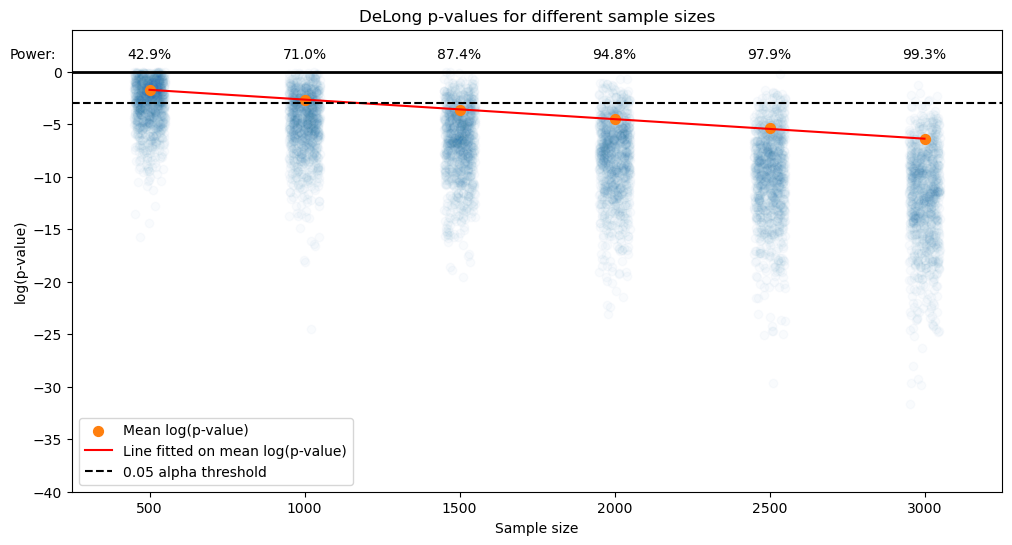

In [25]:
# create a scatter plot of x vs y
plt.figure(figsize=(12, 6))

# add all pvals as dots
plt.scatter(x, y, alpha=0.025)

# add mean pvals as dots
plt.scatter(sample_sizes, np.log(mean_pvals), s=50, label='Mean log(p-value)')

# add a regression line between sample_sizes and np.log(mean_pvals)
m, b = np.polyfit(sample_sizes, np.log(mean_pvals), 1)
plt.plot(sample_sizes, m*sample_sizes + b, color='red', label='Line fitted on mean log(p-value)')

# add powers as text
for i, power in enumerate(powers):
    plt.text(sample_sizes[i], 1, f'{power*100:.1f}%', ha='center', va='bottom')

# add a horizontal line at p-val=0.05
plt.axhline(np.log(0.05), color='black', linestyle='--', label='0.05 alpha threshold')

# add a horizontal line at p-val=1
plt.axhline(np.log(1), color='black', linestyle='-', lw=2)

# add a legend at the bottom right
plt.legend(loc='lower left')

# set limits for the y axis
plt.ylim(-40, 4)
plt.xlim(sample_sizes[0]-l*.5, sample_sizes[-1] + l*.5)

# write "power" in the top left corner
plt.text(sample_sizes[0]-l*.75, 1, 'Power:', ha='center', va='bottom')

# add a label to the x-axis
plt.xlabel('Sample size')

# add a label to the y-axis
plt.ylabel('log(p-value)')

# add a title
plt.title('DeLong p-values for different sample sizes');

Power is calculated for a given sample size as the proportion of p-values below a threshold of interest: here, 0.05. So, for example, we can say the following.

In [26]:
f"At the alpha risk of .05, assuming the distribution form the current test set, a sample size of n={sample_sizes[2]}, would yield a power of {100*powers[2]:.1f}%."

'At the alpha risk of .05, assuming the distribution form the current test set, a sample size of n=1500, would yield a power of 87.4%.'

NB: I noted empirically that if we run many simulations, the mean log(p-value) correlates perfectly linearly with the sample size (see the red line above). Please don't ask me why, I don't know. There certainly is a math proof for that. I bet the multiple testing people know about it.

Now for the full sample size-power correspondance at the 0.05 alpha threshold:

In [27]:
pd.DataFrame({"sample size": sample_sizes, "power": powers})

,sample size,power
0,500,0.429
1,1000,0.710
2,1500,0.874
3,2000,0.948
4,2500,0.979
5,3000,0.993


So, to answer our original question: "How big my test set should be to detect the difference in AUC?" the recipe is this.
1. Pick an alpha threshold
2. Choose a desired power
3. Conduct a simulation study by resampling with replacement from a small "pilot" test set to create datasets of various sample sizes
4. Look at the results and pick a sample size accordingly

## Bonus: estimate power in the absence of prediction models and of a pilot test set

Imagine we have no data and no models at hand. Can we figure out the sample size we’d need to show a significant improvement in discrimination from one model compared to another? We can but there's a price to pay for that and we'll have to make some asumptions about these hypothetical models performance on a test set.

How does this work? Remember what we used ealier to evaluate the power at different sample sizes. Basically, we just resampled from a pilot test set that looked like this:

In [28]:
data_mod.head()

,y,y_hat_rf,y_hat_mlp
0,1,0.584183,0.414781
1,1,0.610146,0.423849
2,1,0.559381,0.443536
3,1,0.941799,0.507029
4,1,0.596773,0.427111


Or in the more general case:

In [29]:
# Rename the columns
data_mod.columns = ['Y', 'Y_hat_A', 'Y_hat_A']
data_mod.head()


,Y,Y_hat_A,Y_hat_A
0,1,0.584183,0.414781
1,1,0.610146,0.423849
2,1,0.559381,0.443536
3,1,0.941799,0.507029
4,1,0.596773,0.427111


And so, if we're given no data and no models but want to move forward, we'll have to make a guess for the distribution of this dataset: $$P_{Y,\hat{Y}_A,\hat{Y}_B}(y,\hat{y}_A,\hat{y}_B)=P_{\hat{Y}_A,\hat{Y}_B|Y}(\hat{y}_A,\hat{y}_B|y)P_Y(y).$$

The equality above follows from Bayes theorem. The right hand side is convenient because now we can separately guess/specify $P_{\hat{Y}_A,\hat{Y}_B|Y}(\hat{y}_A,\hat{y}_B|y)$ and $P_Y(y).$

The distribution $P_Y$ is easy to guess because we know $Y$ is binary, and thus a Bernoulli distribution is appropriate: $$P_Y(y;p)=p^y (1-p)^{1-y}$$ where $p$ is a constant often referred to as the prevalence. 

The conditional distribution $P_{\hat{Y}_A,\hat{Y}_B|Y}(\hat{y}_A,\hat{y}_B|y)$ is trickier because $(\hat{y}_A,\hat{y}_B)$ are probabilities that do not sum to one (see our dataset in `data_mod.head(10)` above.) We'll have to make the assumption that the predictions from the two models are conditionally independant so we can write: $$P_{\hat{Y}_A,\hat{Y}_B|Y}(\hat{y}_A,\hat{y}_B|y)=P_{\hat{Y}_A|Y}(\hat{y}_A|y)\times P_{\hat{Y}_B|Y}(\hat{y}_B|y).$$

Now the puzzle is much easier because we can just posit distributions for $P_{\hat{Y}_A|Y}(\hat{y}_A|0)$, $P_{\hat{Y}_A|Y}(\hat{y}_B|1)$, $P_{\hat{Y}_B|Y}(\hat{y}_A|0)$, and
$P_{\hat{Y}_B|Y}(\hat{y}_A|1)$ separately. Note that these are univariable distributions where the random variable is a probability. [Beta distributions](https://en.wikipedia.org/wiki/Beta_distribution) are natural candidates in this context. Beta distributions take two "shape" parameters called $\alpha$ and $\beta.$ In the Power to Detect Differences in Discrimintion (P3D) app, we let you vary these $2\times4$ parameters. The result is power evaluated at different sample sizes.

<p align="center"><img src="p3d.png" width="500"/></p>

To run your own simulations for power calculation, launch the P3D app by using the following commands in the terminal:
- `cd path/to/P3D`
- `pip install voila`
- `voila P3D.ipynb`

Any other ideas welcomed! Thank you for taking part of this workshop!

## References
- *[Bootstrap Confidence Intervals.](http://users.stat.umn.edu/~helwig/notes/bootci-Notes.pdf)* Nathaniel E. Helwig, Course Notes, 2017.
- *[Comparing AUCs of Machine Learning Models with DeLong’s Test](https://glassboxmedicine.com/2020/02/04/comparing-aucs-of-machine-learning-models-with-delongs-test/)*. Draelos, R., Blog Post. 2020.

- *[Comparing the Areas under Two or More Correlated Receiver Operating Characteristic Curves: A Nonparametric Approach.](https://www.jstor.org/tc/accept?origin=%2Fstable%2Fpdf%2F2531595.pdf%3Fseq%3D1&is_image=False)* DeLong, E., et al. Biometrics 1988. 